In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.data import read_merged
from seminartools.data import read_inflation

# 1. Read data

In [3]:
df = read_merged().reset_index()
df

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:173: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:409: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [4]:
from scipy.signal import gaussian

In [5]:
from seminartools.models.utils import get_stats
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.time_series_split import ExpandingWindowSplit

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("random_effects_1_lag", lambda: RandomEffectsModel()),
        ("random_effects_2_lag", lambda: RandomEffectsModel(lags = 2)),
        ("distance_1_lag", lambda: DistanceModel()),
        ("distance_2_lag", lambda: DistanceModel(lags = 2)),
    ],
    df,
    ExpandingWindowSplit(
        start_date = "2010-01-01",
        num_splits = 1,
    ),
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To

,mse,mae,r2,mz_intercept,mz_slope,mz_r2,mz_wald_test_statistic,p-value
ar,0.000061,0.005502,0.257362,0.000052,0.948273,0.259118,1.209008,0.29892072644883366
random_effects_1_lag,0.000078,0.006256,0.055255,0.001770,0.652718,0.083251,15.528458,2.2750933050451687e-07
distance_1_lag,0.000078,0.006184,0.053681,0.002145,0.611050,0.094487,22.915020,1.844385812399488e-10
random_effects_2_lag,0.000081,0.006361,0.021270,0.002706,0.550616,0.065049,23.740558,8.38920960760473e-11
distance_2_lag,0.000082,0.006402,0.008198,0.002953,0.515621,0.072157,34.949230,2.0990532393797245e-15


In [6]:
subdf = df.query("date <= '2010-01-01'")
model_ar = ARMAXModel(max_p=2, max_q=0)
model_ar.fit(df)
model_re = RandomEffectsModel(lags = 2)
model_re.fit(df)
model_distance = DistanceModel(lags = 2)
model_distance.fit(df)

c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
Creating regression coefficients: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


# Compare coefficients

In [7]:
import arviz as az
from tqdm import tqdm

def get_params(country):
    params_ar = model_ar.models[country].params
    out = {
        "const": params_ar["const"],
    }
    for lag in range(1, len(model_ar.models[country].params) - 1):
        out[f"L{lag}"] = params_ar[f"ar.L{lag}"]
    params_ar = pd.Series(out)
    params_re = az.summary(model_re.results.posterior, round_to = 6)
    out = {
        "const": params_re.loc["Intercept", "mean"] + params_re.loc[f"1|country[{country}]", "mean"]
    }
    for i in range(1, model_re.lags + 1):
        out[f"L{i}"] = params_re.loc[f"inflation_lag_{i}|country[{country}]", "mean"]
    params_re = pd.Series(out)
    country_idx = model_distance.countries.tolist().index(country)
    params_distance = az.summary(model_distance.trace.posterior, round_to = 6)
    params_distance.index
    out = {
        "const": params_distance.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_distance.lags + 1):
        out[f"L{lag}"] = params_distance.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]

    params_distance = pd.Series(out)
    params = pd.concat([
        params_ar,
        params_re,
        params_distance,
    ], axis=1, keys=["ar", "re", "distance"])
    return params

params = pd.concat([
    get_params(country)
    for country in tqdm(model_distance.countries)
], keys=model_distance.countries, axis=0)
params

100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


ar        re  distance
Japan          const -0.330119 -0.216485 -0.213867
               L1     0.118223  0.032384  0.025811
               L2     0.491085  0.426299  0.455526
Canada         const  0.206456  0.056146  0.056592
               L1     0.661475  0.559712  0.582877
               L2          NaN  0.102376  0.091439
United States  const  0.239861  0.095083  0.093460
               L1     0.607452  0.594975  0.623019
               L2          NaN -0.019713 -0.036752
Australia      const  0.410967  0.107657  0.105176
               L1     0.395985  0.390260  0.392847
               L2     0.334892  0.321951  0.332570
New Zealand    const -0.041423 -0.034327 -0.033632
               L1     0.395130  0.346226  0.367929
               L2     0.155159  0.144833  0.149982
Switzerland    const -0.563361 -0.481141 -0.414129
               L1     0.168116  0.033827  0.098309
               L2     0.369313  0.235405  0.281986
Italy          const -0.188280 -0.075569 -0.074149
               L1     0.379221  0.355864  0.362045
               L2     0.210371  0.194949  0.227840
France         const -0.340533 -0.192771 -0.179709
               L1     0.281251  0.223815  0.212916
               L2          NaN  0.133636  0.209957
Portugal       const -0.177446 -0.115425 -0.112996
               L1    -0.104508 -0.104651 -0.104947
               L2     0.478272  0.449259  0.479893
Spain          const -0.153850 -0.070249 -0.069184
               L1    -0.142170 -0.151229 -0.143999
               L2     0.605141  0.576623  0.608835
Sweden         const -0.184349 -0.066262 -0.060460
               L1     0.225690  0.244743  0.244845
               L2     0.491901  0.433474  0.469935
Denmark        const -0.228356 -0.143093 -0.143310
               L1     0.417665  0.391602  0.436906
               L2          NaN -0.036666 -0.060358
United Kingdom const -0.233270 -0.193836 -0.175873
               L1    -0.114030 -0.092375 -0.039859
               L2     0.264790  0.222126  0.248407
Germany        const -0.208878 -0.123172 -0.124664
               L1     0.388598  0.417980  0.514673
               L2          NaN -0.026136 -0.093393
Netherlands    const -0.158088 -0.113884 -0.105642
               L1     0.436523  0.401347  0.429838
               L2    -0.187616 -0.159354 -0.155872
Norway         const -0.129210 -0.123913 -0.127046
               L1    -0.000534 -0.003332  0.005964
               L2          NaN -0.028041 -0.018826
Belgium        const -0.142292 -0.065106 -0.088923
               L1     0.465026  0.405263  0.423794
               L2          NaN  0.052207  0.022049
Korea          const -0.092459 -0.055686 -0.055784
               L1     0.091647  0.096521  0.101896
               L2     0.156743  0.132070  0.157104
South Africa   const  0.749296  0.566918  0.632845
               L1     0.279400  0.185242  0.184309
               L2          NaN -0.027554 -0.068031
Türkiye        const  1.948558  1.408495  1.639790
               L1     0.067755  0.119433  0.076564
               L2          NaN  0.121824  0.081513

In [8]:
import seaborn as sns

#cm = sns.light_palette("pink", as_cmap=True)
# get coolwarm cmap
cm = sns.color_palette("coolwarm", as_cmap=True)
params.style.background_gradient(cmap=cm)



<Axes: title={'center': 'Second Lag'}, ylabel='Count'>

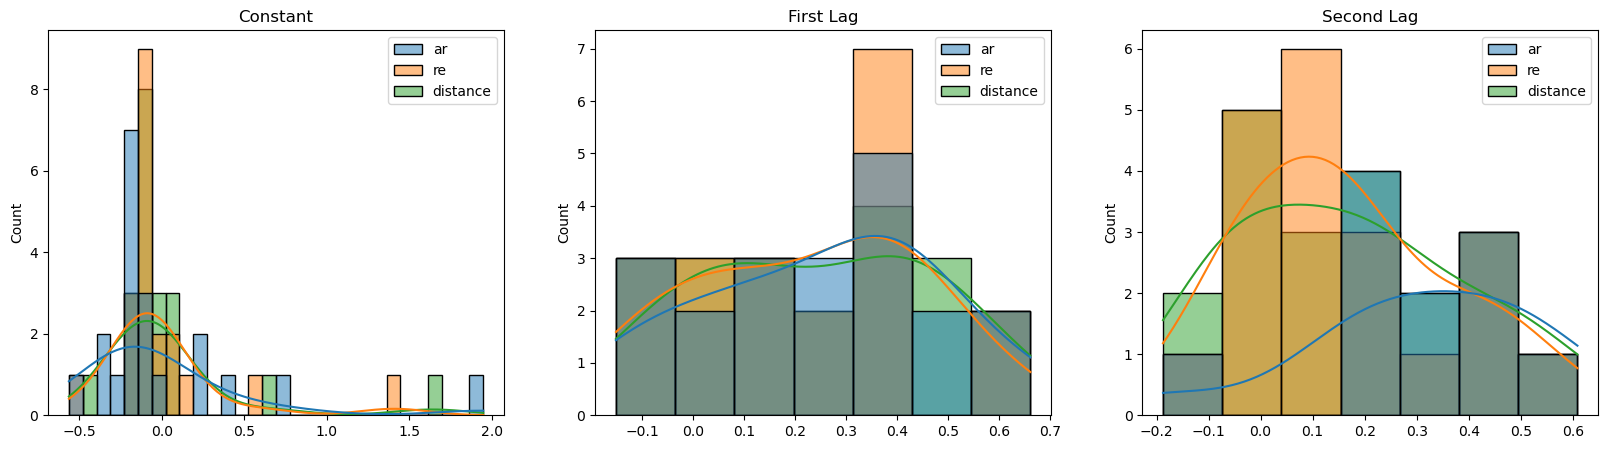

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
frame_use = params.reset_index()
const_frame = frame_use[frame_use["level_1"] == "const"]
L1_frame = frame_use[frame_use["level_1"] == "L1"]
L2_frame = frame_use[frame_use["level_1"] == "L2"]

figures, axis = plt.subplots(1,3,figsize=(20,5))
axis[0].set_title("Constant")
axis[1].set_title("First Lag")
axis[2].set_title("Second Lag")

sns.histplot(
    data = const_frame,
    kde=True,
    ax= axis[0],
)

sns.histplot(
    data=L1_frame,
    kde=True,
    ax= axis[1]
)

sns.histplot(
    data=L2_frame,
    kde=True,
    ax= axis[2]
)

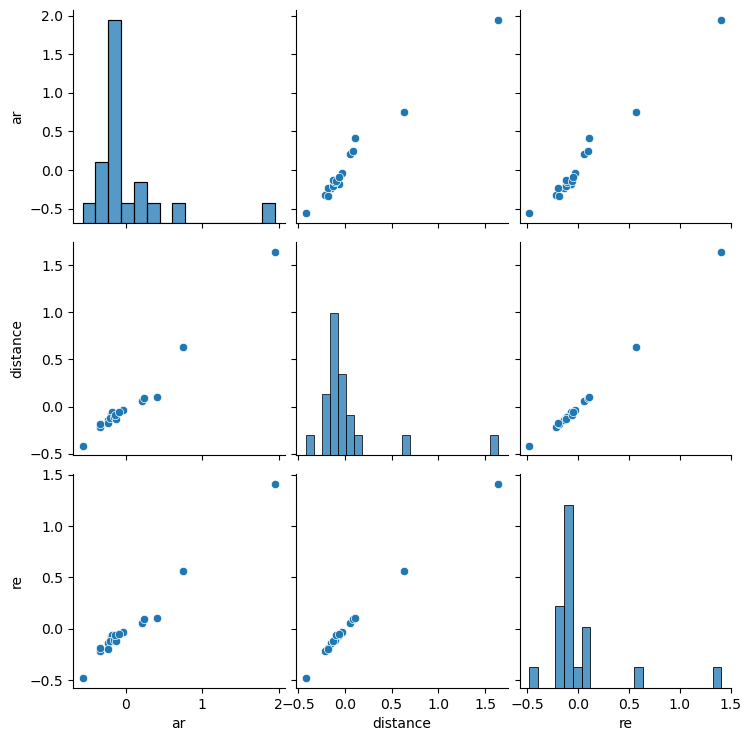

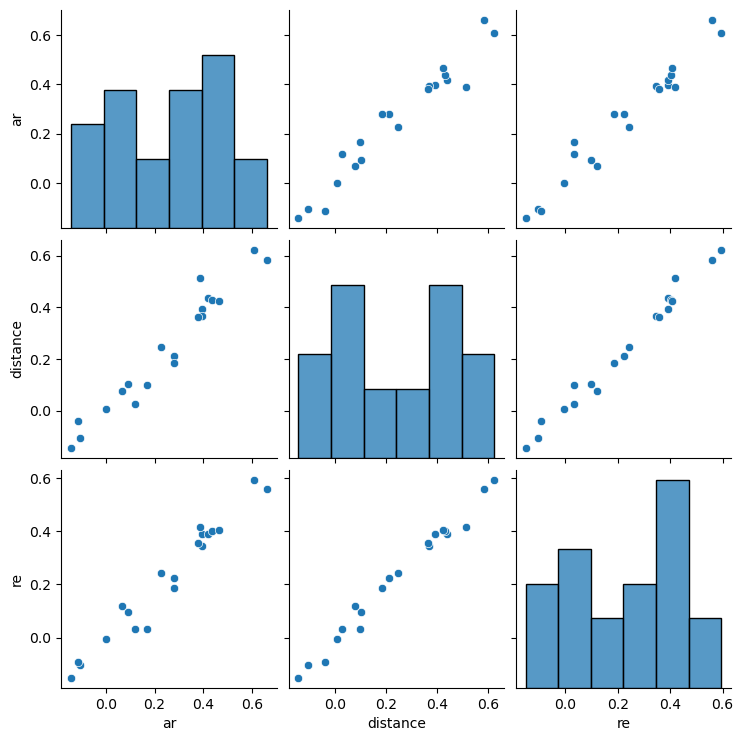

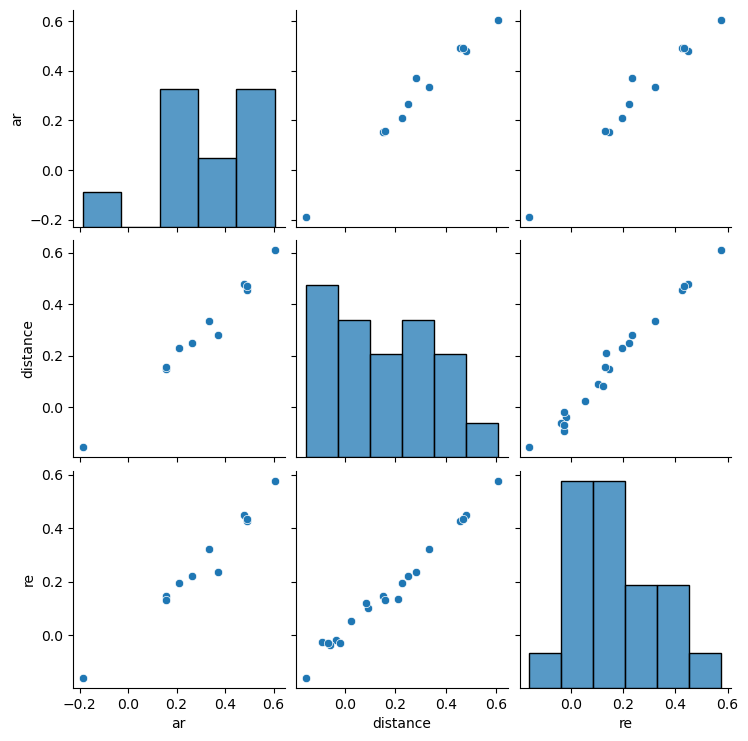

In [11]:
#note that mostly the ar constants are different from the other two models. 
#The lagged coefficients are very similar along models

from mpl_toolkits.mplot3d import Axes3D
sns.pairplot(const_frame[['ar','distance', 're']])
sns.pairplot(L1_frame[['ar','distance', 're']])
sns.pairplot(L2_frame[['ar','distance', 're']])

# Compare forecasts

pred_ar   pred_re  pred_distance
date       country                                         
2010-01-01 Japan         -0.000517  0.001779       0.001596
           Canada         0.004423  0.004230       0.004007
           United States  0.004770  0.007579       0.007475
           Australia      0.008212  0.008061       0.007950
           New Zealand    0.004304  0.008475       0.008586
...                            ...       ...            ...
2023-01-01 Norway         0.005842  0.005421       0.005439
           Belgium        0.017570  0.014052       0.013941
           Korea          0.006746  0.008612       0.009037
           South Africa   0.012052  0.016062       0.015024
2021-01-01 Türkiye        0.025702  0.024056       0.024228

[1060 rows x 3 columns]

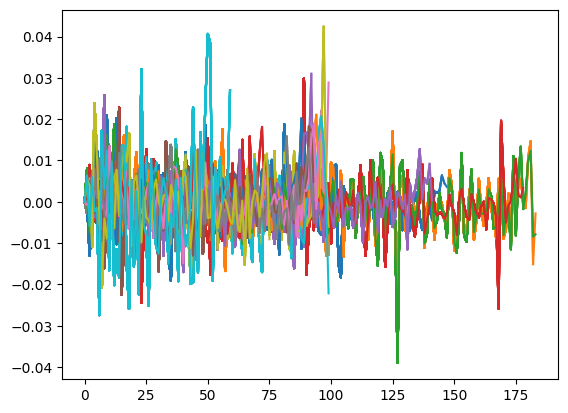

In [45]:
from seminartools.models.utils import h_period_ahead_forecast

preds = pd.concat(
    [
        h_period_ahead_forecast(
            model,
            df,
            h=1,
            start_date="2010-01-01",
        )
        .set_index(["date", "country"])["inflation"].rename(f"pred_{name}")
        #.rename(columns = {"inflation": f"pred_{name}"})
        for model, name in [
            (model_ar, "ar"),
            (model_re, "re"),
            (model_distance, "distance"),
        ]
    ], axis=1
)
preds

In [46]:
merged = preds.merge(df[["inflation", "date", "country"]], left_index=True, right_on = ["date", "country"]).set_index(["date", "country"]).dropna()
merged

pred_ar   pred_re  pred_distance  inflation
date       country                                                    
2010-01-01 Japan         -0.000517  0.001779       0.001596   0.000000
           Canada         0.004423  0.004230       0.004007   0.004405
           United States  0.004770  0.007579       0.007475   0.004014
           Australia      0.008212  0.008061       0.007950   0.009132
           New Zealand    0.004304  0.008475       0.008586   0.003659
...                            ...       ...            ...        ...
2023-01-01 Netherlands    0.002497  0.016483       0.017581  -0.013667
           Norway         0.005842  0.005421       0.005439   0.006886
           Belgium        0.017570  0.014052       0.013941  -0.003628
           Korea          0.006746  0.008612       0.009037   0.010538
           South Africa   0.012052  0.016062       0.015024   0.011202

[1016 rows x 4 columns]

In [49]:
from sklearn.metrics import mean_squared_error

for col in ["pred_ar", "pred_re", "pred_distance"]:
    print(f"{col}: {mean_squared_error(merged['inflation'], merged[col]):.2g}")

pred_ar: 4.9e-05
pred_re: 7.5e-05
pred_distance: 7.6e-05
